In [ ]:
import urllib.request
from pathlib import Path
import re
import itertools as it
import zipfile
import io
import collections
from typing import Iterator, Tuple, List, Callable
from dataclasses import dataclass
import sys

import numpy as np
import scipy as sp
import torch as T
import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [ ]:
DATA = Path("data")
DATA.mkdir(exist_ok=True)
if not (DATA / "raw.zip").is_file():
    urllib.request.urlretrieve(
        "http://www.truth.info/bigfiles/bible.txt.zip",
        DATA / "raw.zip"
    )

REF_PATTERN = re.compile(r"^(.+) (\d+(:\d+)?)$")
def read_raw() -> Iterator[Tuple[str, str, str]]:
    raw = zipfile.ZipFile(DATA / "raw.zip")
    for line in io.TextIOWrapper(raw.open("bible.txt", "r")):
        ref, verse = line.rstrip("\n").split("\t")
        m = REF_PATTERN.match(ref)
        yield (m.group(1), m.group(2), verse)

@dataclass
class Dataset:
    training: List[str]
    validation: List[str]


HELD_OUT = {"Romans"}
def build_dataset() -> Dataset:
    training, validation = [], []
    for book, _, verse in read_raw():
        if book in HELD_OUT:
            validation.append(verse)
        else:
            training.append(verse)
    return Dataset(training, validation)

DATASET = build_dataset()
SEPARATOR = "\n"
VOCAB = tuple(sorted({ch for part in [DATASET.training, DATASET.validation]
                      for line in part
                      for ch in line} | {SEPARATOR}))
def to_ids(line: str) -> np.ndarray:
    return np.array([VOCAB.index(ch) for ch in line])
def to_str(line: np.ndarray) -> str:
    return "".join(VOCAB[ch] for ch in line)

def training_batches(batch_size: int, sequence_length: int) -> Iterator[np.ndarray]:
    ids = to_ids(SEPARATOR.join(DATASET.training))
    while True:
        yield np.stack([
            ids[offset:offset + sequence_length]
            for offset in np.random.randint(len(ids) - sequence_length, size=batch_size)
        ])

def get_validation_batch(sequence_length: int) -> np.ndarray:
    ids = to_ids(SEPARATOR.join(DATASET.validation))
    nseq = len(ids) // sequence_length
    return ids[:nseq * sequence_length].reshape(nseq, sequence_length)


EG_BATCH = next(iter(training_batches(2, 32)))

In [ ]:
class CoreGRU(T.nn.Module):
    def __init__(self, hidden_size: int, depth: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.depth = depth
        self.gru = T.nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=depth,
            batch_first=True,
        )

    def forward(self, x: T.FloatTensor) -> T.FloatTensor:
        self._hiddens = self.gru(x)[0]
        return self._hiddens

class Boom(T.nn.Module):
    def __init__(self, hidden_size: int, multiplier: float, slope: float):
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = int(hidden_size * multiplier)
        self.slope = slope
        self.up = T.nn.Linear(hidden_size, self.intermediate_size)
        self.down = T.nn.Linear(self.intermediate_size, hidden_size)

    def forward(self, x: T.FloatTensor) -> T.FloatTensor:
        x = self.up(x)
        x = T.relu(x) if self.slope == 0 else T.nn.functional.leaky_relu(x, self.slope)
        x = self.down(x)
        return x

class RelaxedBinaryGate(T.autograd.Function):
    """A binary gate in the forward pass, hard tanh in the backward pass."""
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return T.sign(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output * (T.abs_(input) <= 1)

relaxed_binary_gate = RelaxedBinaryGate.apply

class CoreHighway(T.nn.Module):
    def __init__(self, hidden_size: int, nonlinearity: Callable[[T.FloatTensor], T.FloatTensor]):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = T.nn.Linear(2 * hidden_size, 3 * hidden_size)
        self.h0 = T.nn.Parameter(T.zeros(hidden_size))
        self.nonlinearity = nonlinearity

    def forward(self, x: T.FloatTensor) -> T.FloatTensor:
        state = T.tile(self.h0, (x.shape[0], 1))
        states = []
        for step in range(x.shape[1]):
            gates = self.gates(T.cat([state, x[:, step, :]], dim=-1))
            candidate, carry, update = T.split(gates, self.hidden_size, dim=-1)
            state = self.nonlinearity(T.sigmoid(carry) * state + T.sigmoid(update) * candidate)
            states.append(state)
        self._hiddens = T.stack(states, dim=1)
        return self._hiddens

class CoreHighwayV2(T.nn.Module):
    def __init__(self, hidden_size: int, nonlinearity: Callable[[T.FloatTensor], T.FloatTensor]):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = T.nn.Linear(2 * hidden_size, 3 * hidden_size)
        self.step = T.nn.Linear(hidden_size, 3 * hidden_size)
        self.h0 = T.nn.Parameter(T.zeros(hidden_size))
        self.nonlinearity = nonlinearity

    def forward(self, x: T.FloatTensor) -> T.FloatTensor:
        state = T.tile(self.h0, (x.shape[0], 1))
        states = []
        for step in range(x.shape[1]):
            gates = self.gates(T.cat([state, x[:, step, :]], dim=-1))
            candidate, carry, update = T.split(gates, self.hidden_size, dim=-1)
            state = T.sigmoid(carry) * state + T.sigmoid(update) * candidate
            candidate, carry, update = T.split(self.step(state), self.hidden_size, dim=-1)
            state = self.nonlinearity(T.sigmoid(carry) * state + T.sigmoid(update) * candidate)
            states.append(state)
        self._hiddens = T.stack(states, dim=1)
        return self._hiddens

class CoreConv(T.nn.Module):
    def __init__(self, hidden_size: int, width: int, depth: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.width = width
        self.depth = depth
        self.convs = T.nn.ModuleList([
            T.nn.Conv1d(hidden_size, hidden_size, width)
            for _ in range(depth)
        ])

    def forward(self, x: T.FloatTensor) -> T.FloatTensor:
        x = x.transpose(1, 2)
        for conv in self.convs:
            x = T.nn.functional.pad(x, (self.width - 1, 0, 0, 0))
            x = conv(x)
            x = T.relu(x)
        x = x.transpose(1, 2)
        return x

class CoreStack(T.nn.ModuleList):
    def __init__(self, *children: T.nn.Module):
        super().__init__(children)

    @property
    def hidden_size(self):
        return self[0].hidden_size

    def forward(self, x: T.FloatTensor) -> T.FloatTensor:
        for layer in self:
            x = layer(x)
        return x

class Model(T.nn.Module):
    def __init__(self, core: T.nn.Module):
        super().__init__()
        self.embedding = T.nn.Embedding(len(VOCAB), core.hidden_size)
        self.core = core
        self.prediction = T.nn.Linear(core.hidden_size, len(VOCAB))

    def forward(self, x: T.LongTensor) -> T.FloatTensor:
        return self.prediction(self.core(self.embedding(x)))

    def loss(self, x: T.LongTensor) -> T.FloatTensor:
        predictions = self(x[:, :-1])
        return T.nn.functional.cross_entropy(
            predictions.reshape(-1, len(VOCAB)), x[:, 1:].flatten()
        )

Model(CoreStack(
    CoreConv(8, 3, 1),
    CoreHighwayV2(8, relaxed_binary_gate),
    Boom(8, 2, 0.01),
)).loss(T.LongTensor(EG_BATCH))

tensor(4.1532, grad_fn=<NllLossBackward>)

In [ ]:
def train(model: T.nn.Module,
          batch_size: int,
          sequence_length: int,
          steps: int,
          validation_interval: int) -> Tuple[np.ndarray, np.ndarray]:
    losses = []
    validation_losses = []
    validation_batch = get_validation_batch(sequence_length)
    t = tqdm.tqdm(
        it.islice(training_batches(batch_size, sequence_length), steps),
        total=steps, position=0, leave=True,
    )
    optimizer = T.optim.Adam(model.parameters(), 0.001)
    for n, batch in enumerate(t):
        if n % validation_interval == 0:
            validation_loss = model.loss(T.LongTensor(validation_batch).cuda())
            validation_losses.append(float(validation_loss))
            t.set_postfix(loss=np.mean(losses[-100:]) if losses else None,
                          vloss=float(validation_loss))
        optimizer.zero_grad()
        loss = model.loss(T.LongTensor(batch).cuda())
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

    return np.array(losses), np.array(validation_losses)

HIDDEN_SIZE = 128
MODEL = Model(CoreStack(
    CoreHighway(HIDDEN_SIZE, relaxed_binary_gate),
    # CoreGRU(HIDDEN_SIZE, 1),
    Boom(HIDDEN_SIZE, 4, 0),
    Boom(HIDDEN_SIZE, 4, 0),
)).cuda()
LOSSES, VALIDATION_LOSSES = train(MODEL, 32, 512, steps=int(1e4), validation_interval=100)

100%|██████████| 10000/10000 [48:21<00:00,  3.45it/s, loss=1.12, vloss=1.3]


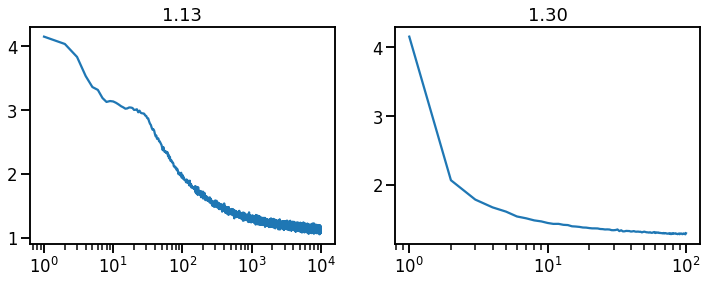

In [ ]:
def show(losses, avg, ax):
    ax.plot(np.arange(1, len(losses) + 1), losses)
    ax.set_xscale("log")
    ax.set_title(f"{losses[-100:].mean() if avg else losses[-1]:.2f}")

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
show(LOSSES, avg=True, ax=ax0)
show(VALIDATION_LOSSES, avg=False, ax=ax1)

In [ ]:
# B=32, S=512, lr=1e-3, 10k steps
#
# Conv 128w5d3 : 1.25(1.04) 83it/s
# Conv 128w3d5 : 1.24(1.04) 78it/s
# Conv 128w9d1 : 1.40(1.22) 150it/s
#
# GRU  128d1   : 1.24(1.06) 51it/s
# GRU  128d2   : 1.17(0.96) 38it/s
# GRU  128d3   : 1.15(0.92) 25it/s
#
# CGC  128-w3d1-d1-w3d1 : 1.19(0.99) 41it/s
# GRU  256d1            : 1.16(0.93) 32it/s
#
# GB   128d1b4   : 1.18(0.98) 39it/s
# GBl  128d1b4   : 1.18(0.98) 39it/s (leaky 0.01)
# GBB  128d1b4b4 : 1.16(0.95) 35it/s
# GB   128d1b8   : 1.18(0.95) 37it/s
#
# HBl  128  : 1.16(0.96) 3.9it/s  -- s(carry) * state + s(update) * t(candidate)
# HbB1 128  : 1.35(1.19) 3.6it/s  -- b(s(carry) * state + s(update) * candidate)
# HbBB 128  : 1.30(1.13) 3.5it/s
#  (1k V2: 2.23it/s, loss=1.28, vloss=1.42)
#  (1k V1: 3.37it/s, loss=1.32, vloss=1.45)
#

In [ ]:
TEST_SEQUENCES = SEPARATOR.join(DATASET.validation[15:][:2])
MODEL.loss(T.LongTensor(to_ids(TEST_SEQUENCES)[np.newaxis]).cuda())
STATES = MODEL.core[0]._hiddens.detach().cpu().numpy()[0]
STATES.shape, TEST_SEQUENCES

((274, 128),
 'For I am not ashamed of the gospel of Christ: for it is the power of God unto salvation to every one that believeth; to the Jew first, and also to the Greek.\nFor therein is the righteousness of God revealed from faith to faith: as it is written, The just shall live by faith.')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
PATH = Path("/content/drive/MyDrive/Colab Notebooks/2021-04-BibleText/v0.npy")
assert not PATH.exists()
np.save(PATH, STATES)

Mounted at /content/drive
MyDrive
